In [1]:
from arch.unitroot.cointegration import engle_granger
from pykalman import KalmanFilter
from scipy.optimize import minimize
from statsmodels.tsa.vector_ar.vecm import VECM

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()



In [2]:
assets = ["EURUSD=X", "GBPUSD=X", "USDCAD=X", "USDHKD=X", "USDJPY=X"]

In [37]:
from pykrx import stock

In [38]:
korea_tick = stock.get_market_ticker_list('2022-01-01', 'KOSPI')

In [39]:
korea_tick = [str(x) + '.KS' for x in korea_tick]

In [3]:
import yfinance as yf

In [4]:
history = yf.download(assets)['Close']

[*********************100%***********************]  5 of 5 completed


In [66]:
history = yf.download(korea_tick[0:100])['Adj Close']

[*********************100%***********************]  100 of 100 completed

1 Failed download:
- 016385.KS: No data found, symbol may be delisted


In [67]:
history.index = pd.to_datetime(history.index)
history = history.sort_index(ascending=True)
history = history[history.loc['2012-01-02':].iloc[0].dropna().index].dropna()

In [68]:
np_hist = np.log(history).dropna(axis=0)

In [102]:
np_hist

,000040.KS,000120.KS,000210.KS,000215.KS,000590.KS,000680.KS,000990.KS,000995.KS,001040.KS,001045.KS,...,097950.KS,097955.KS,105560.KS,108670.KS,108675.KS,114090.KS,119650.KS,138930.KS,139130.KS,175330.KS
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-23,8.406485,11.225243,11.230255,9.533344,10.413448,8.363713,8.866354,9.119225,10.963393,9.450891,...,12.478340,10.869197,10.159496,11.244573,9.741551,9.512243,9.136608,8.888539,9.029117,8.064180
2011-12-26,8.349957,11.217211,11.230255,9.539945,10.393158,8.351163,8.849169,9.111767,10.964701,9.453425,...,12.480057,10.869197,10.150055,11.237564,9.741551,9.517752,9.131068,8.879530,9.029117,8.070174
2011-12-27,8.310906,11.229235,11.219180,9.533344,10.381376,8.336125,8.805566,9.093418,10.956827,9.470992,...,12.467977,10.873561,10.154112,11.222206,9.750304,9.509477,9.079774,8.897468,9.029117,8.068180
2011-12-28,8.290041,11.241117,11.209368,9.535049,10.385810,8.345515,8.824877,9.095594,10.952165,9.470992,...,12.498262,10.878767,10.164245,11.263510,9.790578,9.470369,9.069342,8.906600,9.044621,8.087230
2011-12-29,8.291546,11.225243,11.221693,9.548382,10.429107,8.369752,8.815268,9.095594,10.979817,9.476133,...,12.479442,10.874306,10.153286,11.268124,9.794954,9.538577,9.063300,8.911136,9.036899,8.070836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-14,6.385194,11.407565,11.098924,10.509169,10.950807,7.882315,10.727663,11.497812,11.250261,10.789319,...,12.940842,12.066811,10.812754,10.491274,9.775654,9.732106,7.646224,8.818778,8.845057,8.913281
2022-11-15,6.376727,11.426278,11.104957,10.505068,10.969921,7.872836,10.799576,11.512925,11.277203,10.804665,...,12.890431,12.046491,10.811746,10.515967,9.784141,9.732106,7.736307,8.827615,8.860783,8.922658
2022-11-16,6.368187,11.414209,11.095894,10.502324,10.973357,7.882315,10.802632,11.497812,11.283512,10.809728,...,12.879017,12.037654,10.821776,10.517321,9.761348,9.746834,7.755767,8.839277,8.894259,8.951570


In [114]:
from itertools import combinations as cb

cb_list = list(cb((np_hist.columns), 2))

In [117]:
np_hist[list(cb_list[0])]

,000040.KS,000120.KS
Date,,
2011-12-23,8.406485,11.225243
2011-12-26,8.349957,11.217211
2011-12-27,8.310906,11.229235
2011-12-28,8.290041,11.241117
2011-12-29,8.291546,11.225243
...,...,...
2022-11-14,6.385194,11.407565
2022-11-15,6.376727,11.426278
2022-11-16,6.368187,11.414209


In [119]:
for x in cb_list[0:10]:
    print(x[0], x[1])

000040.KS 000120.KS
000040.KS 000210.KS
000040.KS 000215.KS
000040.KS 000590.KS
000040.KS 000680.KS
000040.KS 000990.KS
000040.KS 000995.KS
000040.KS 001040.KS
000040.KS 001045.KS
000040.KS 001060.KS


In [127]:
beta.shape

(81, 4)

In [125]:
np_hist[df_idx]

,000040.KS,000120.KS
Date,,
2011-12-23,8.406485,11.225243
2011-12-26,8.349957,11.217211
2011-12-27,8.310906,11.229235
2011-12-28,8.290041,11.241117
2011-12-29,8.291546,11.225243
...,...,...
2022-11-14,6.385194,11.407565
2022-11-15,6.376727,11.426278
2022-11-16,6.368187,11.414209


In [130]:
VECM(np_hist, k_ar_diff=0, coint_rank=len(assets)-1, deterministic='n').fit().beta.shape

/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


(81, 4)

In [ ]:
np_hist[]

In [146]:
beta.shape[1]

1

/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


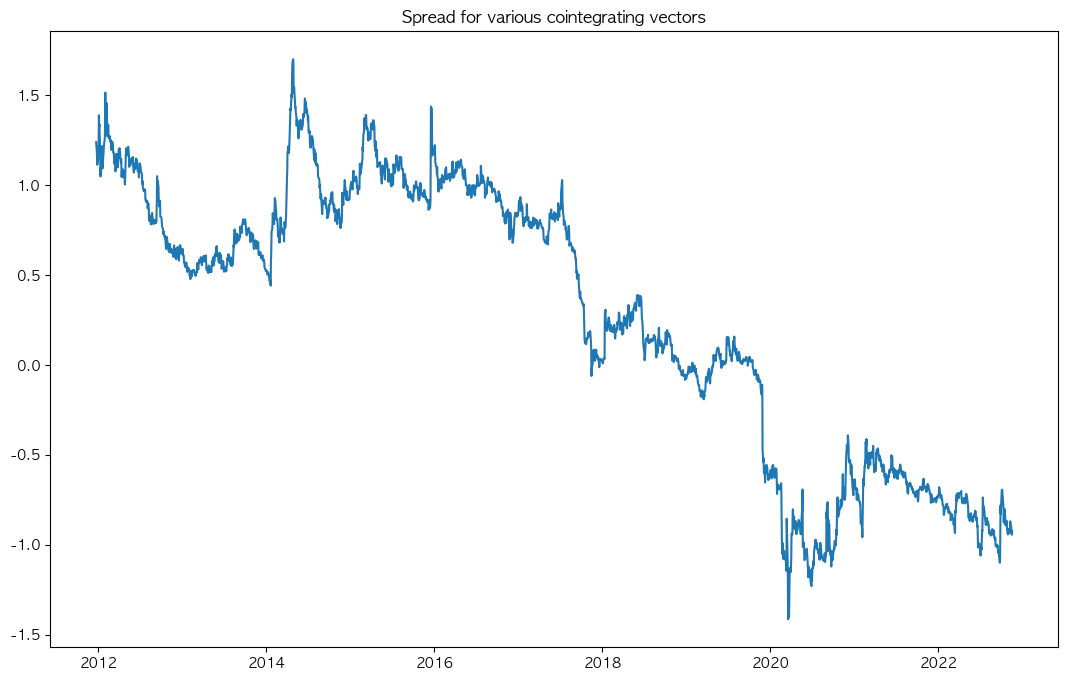

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [151]:
for idx in cb_list[0:10]:

    asset1 = idx[0]
    asset2 = idx[1]
    df_idx = list(idx)

    value_reg = []

    coint_result = engle_granger(np_hist[asset1], np_hist[asset2], trend='n', method='bic')
    coint_result.summary()
    vecm_result = VECM(np_hist[df_idx], k_ar_diff=0, coint_rank=len(df_idx)-1, deterministic='n').fit()
    beta = vecm_result.beta
    beta
    spread = np_hist[df_idx] @ beta

    plt.figure(figsize=(13, 8), facecolor='w')
    plt.title('Spread for various cointegrating vectors')
    plt.plot(spread)
    #axs.set_title(f"The {i+1}th normalized cointegrating subspace")
    plt.show()

    x0 = np.array([-1**i/beta.shape[1] for i in range(beta.shape[1])]).reshape(1,1)
    bounds = tuple((-1, 1) for i in range(beta.shape[1]))
    constraints = [{'type':'eq', 'fun':lambda x: np.sum(x)}]
    opt = minimize(lambda w: ((w.T @ np.cov(spread.T, spread.shift(1).fillna(0).T)[spread.shape[1]:, :spread.shape[1]] @ w)/(w.T @ np.cov(spread.T) @ w))**2,
                x0=x0,
                bounds=bounds,
                constraints=constraints,
                method="SLSQP")
    opt.x = opt.x/np.sum(abs(opt.x))

    for i in range(len(opt.x)):
        print(f"The weight put on {i+1}th normalized cointegrating subspace: {opt.x[i]}")

    new_spread = spread @ opt.x
    new_spread.plot(title="Weighted spread", figsize=(15, 10))
    plt.ylabel("Spread")
    plt.show()

    kalmanFilter = KalmanFilter(transition_matrices = [1],
                    observation_matrices = [1],
                    initial_state_mean = new_spread.iloc[:20].mean(),
                    observation_covariance = new_spread.iloc[:20].var(),
                    em_vars=['transition_covariance', 'initial_state_covariance'])
    kalmanFilter = kalmanFilter.em(new_spread.iloc[:20], n_iter=5)
    (filtered_state_means, filtered_state_covariances) = kalmanFilter.filter(new_spread.iloc[:20])

    currentMean = filtered_state_means[-1, :]
    currentCov = filtered_state_covariances[-1, :]
    mean_series = np.array([None]*(new_spread.shape[0]-100))

    for i in range(100, new_spread.shape[0]):
        (currentMean, currentCov) = kalmanFilter.filter_update(filtered_state_mean = currentMean,
                                                            filtered_state_covariance = currentCov,
                                                            observation = new_spread.iloc[i])
        mean_series[i-100] = float(currentMean)
    mean_series.shape
    normalized_spread = (new_spread.iloc[100:] - mean_series)
    normalized_spread.shape

    plt.figure(figsize=(15, 10))
    plt.plot(normalized_spread, label="Processed spread")
    plt.title(f"Normalized spread series {asset1} & {asset2}")
    plt.ylabel("Spread - Expectation")
    plt.legend()
    plt.show()

    s0 = np.linspace(0, max(normalized_spread), 50)
    f_bar = np.array([None]*50)
    for i in range(50):
        f_bar[i] = len(normalized_spread.values[normalized_spread.values > s0[i]]) / normalized_spread.shape[0]

    D = np.zeros((49, 50))
    for i in range(D.shape[0]):
        D[i, i] = 1
        D[i, i+1] = -1
    l = 1.0

    f_star = np.linalg.inv(np.eye(50) + l * D.T@D) @ f_bar.reshape(-1, 1)
    s_star = [f_star[i]*s0[i] for i in range(50)]
    threshold = s0[s_star.index(max(s_star))]

    print(f"The optimal threshold is {threshold}")
    plt.figure(figsize=(15, 10))
    plt.plot(s0, s_star)
    plt.title("Profit of mean-revertion trading")
    plt.xlabel("Threshold")
    plt.ylabel("Profit")
    plt.show()

    trading_weight = beta @ opt.x
    trading_weight /= np.sum(abs(trading_weight))
    testing_ret = history.pct_change().dropna().shift(-1)   # Shift 1 step backward as forward return result
    equity = pd.DataFrame(np.ones((testing_ret.shape[0], 1)), index=testing_ret.index, columns=["Daily value"])
    buy_period = normalized_spread[normalized_spread < -threshold].index
    sell_period = normalized_spread[normalized_spread > threshold].index
    equity.loc[buy_period, "Daily value"] = testing_ret.loc[buy_period] @ trading_weight + 1
    equity.loc[sell_period, "Daily value"] = testing_ret.loc[sell_period] @ -trading_weight + 1
    value = equity.cumprod()

    value.plot(title="Equity Curve", figsize=(15, 10))
    plt.ylabel("Portfolio Value")
    plt.show()

    value_reg.append(value)

In [71]:
coint_result = engle_granger(np_hist.iloc[:,0], np_hist.iloc[:,1], trend='n', method='bic')

In [152]:
coint_result.summary()

Test Statistic,-1.028
P-value,0.696
ADF Lag length,0
Estimated Root ρ (γ+1),0.999


In [74]:
beta = vecm_result.beta
beta

array([[ 1.00000000e+00, -1.64295049e-16, -2.08126060e-17,
         4.48692565e-17],
       [-1.90722591e-16,  1.00000000e+00,  1.88270926e-16,
        -2.68337413e-17],
       [ 1.71165942e-16,  3.47277623e-16,  1.00000000e+00,
        -1.85729930e-15],
       [ 9.29856774e-17, -1.50450815e-16,  3.02002379e-16,
         1.00000000e+00],
       [-1.79083428e+00, -2.50355314e-01, -5.46789196e+00,
        -1.03060596e+01],
       [ 2.73179368e+00,  2.98063555e+00, -8.58013166e+00,
        -1.78296600e+01],
       [-6.79769490e-02,  1.35282367e+00, -4.04593221e+00,
        -8.13586110e+00],
       [ 8.75949145e-01, -2.24510827e-02, -2.60617234e-02,
        -7.30948733e-01],
       [ 8.39838366e+00,  4.99536602e+00, -1.31948247e+01,
        -2.83608478e+01],
       [-6.82658496e+00, -1.66060927e+00,  7.94234594e+00,
         1.79621922e+01],
       [-7.17775032e-01, -1.70377124e+00,  3.51757072e+00,
         8.40608232e+00],
       [ 1.37690892e-01, -4.85701750e-01,  2.60233096e+00,
      

In [134]:
np_hist @ beta

,0,1,2,3
Date,,,,
2011-12-23,1.082783,1.491982,-4.054347,-8.825521
2011-12-26,0.480358,1.178261,-2.851391,-6.231847
2011-12-27,0.343584,1.708156,-4.017194,-8.538670
2011-12-28,-0.477572,1.092761,-2.503613,-5.174911
2011-12-29,-0.301230,1.235427,-3.193778,-6.566403
...,...,...,...,...
2022-11-14,0.846886,0.289692,-0.782341,-1.680462
2022-11-15,1.100101,0.508886,-0.950171,-2.223207
2022-11-16,0.983699,0.281937,-0.209545,-0.688862


In [75]:
spread = np_hist @ beta


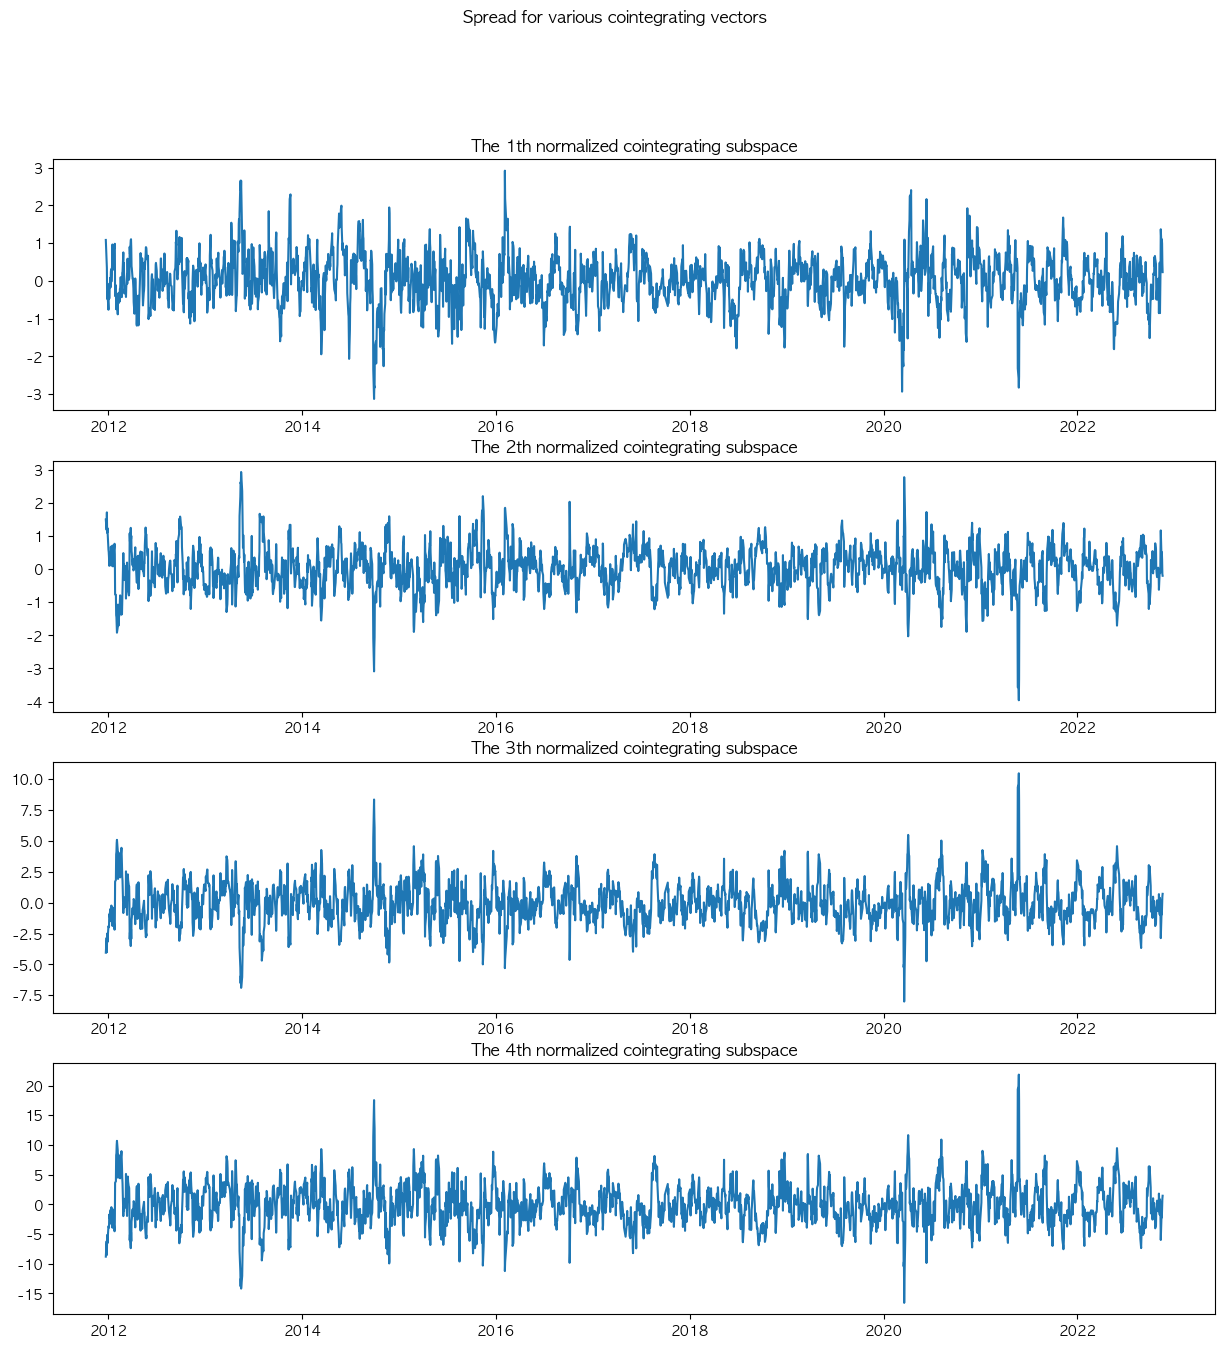

In [76]:
fig, axs = plt.subplots(beta.shape[1], figsize=(15, 15))
fig.suptitle('Spread for various cointegrating vectors')
for i in range(beta.shape[1]):
    axs[i].plot(spread.iloc[:, i])
    axs[i].set_title(f"The {i+1}th normalized cointegrating subspace")
plt.show()

In [77]:
x0 = np.array([-1**i/beta.shape[1] for i in range(beta.shape[1])])
bounds = tuple((-1, 1) for i in range(beta.shape[1]))
constraints = [{'type':'eq', 'fun':lambda x: np.sum(x)}]

In [78]:
opt = minimize(lambda w: ((w.T @ np.cov(spread.T, spread.shift(1).fillna(0).T)[spread.shape[1]:, :spread.shape[1]] @ w)/(w.T @ np.cov(spread.T) @ w))**2,
               x0=x0,
               bounds=bounds,
               constraints=constraints,
               method="SLSQP")

In [79]:
opt.x = opt.x/np.sum(abs(opt.x))
for i in range(len(opt.x)):
    print(f"The weight put on {i+1}th normalized cointegrating subspace: {opt.x[i]}")

The weight put on 1th normalized cointegrating subspace: 0.03589362712462801
The weight put on 2th normalized cointegrating subspace: -0.22766598553522482
The weight put on 3th normalized cointegrating subspace: 0.46410637287537193
The weight put on 4th normalized cointegrating subspace: -0.2723340144647751


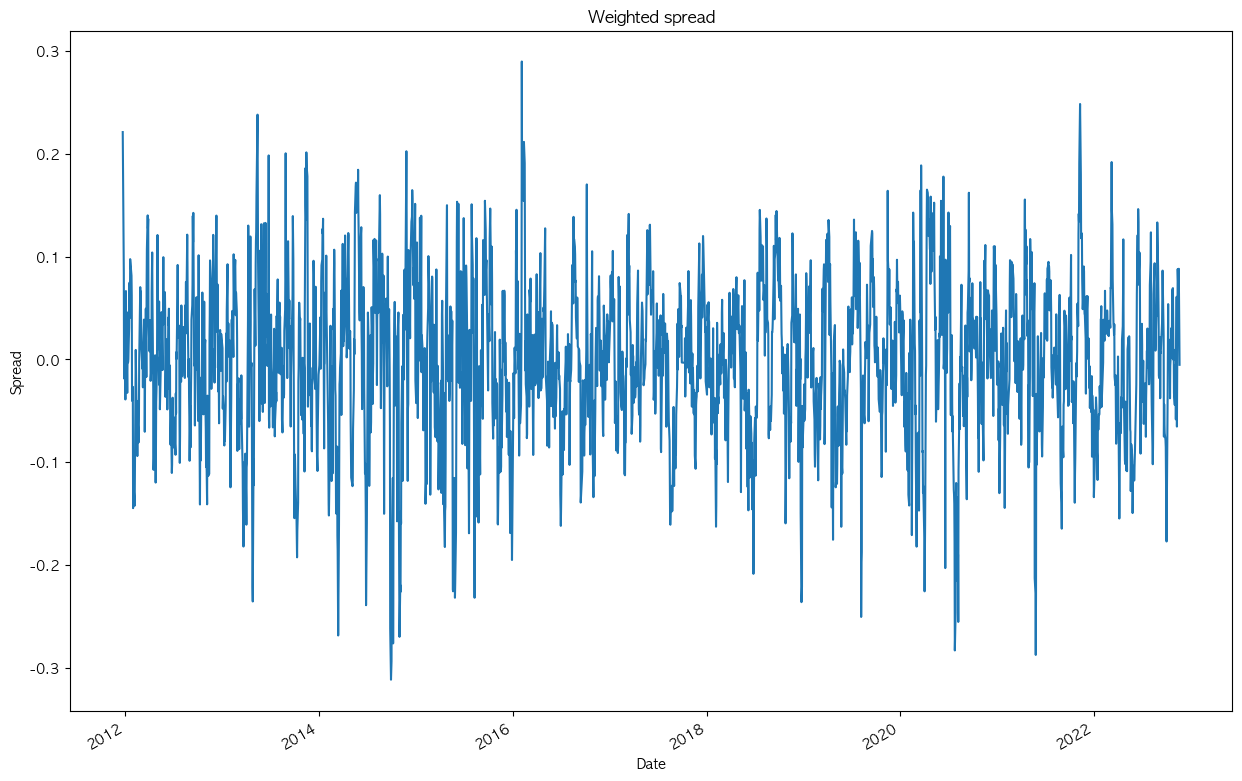

In [80]:
new_spread = spread @ opt.x
new_spread.plot(title="Weighted spread", figsize=(15, 10))
plt.ylabel("Spread")
plt.show()

In [81]:
kalmanFilter = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = new_spread.iloc[:20].mean(),
                  observation_covariance = new_spread.iloc[:20].var(),
                  em_vars=['transition_covariance', 'initial_state_covariance'])
kalmanFilter = kalmanFilter.em(new_spread.iloc[:20], n_iter=5)
(filtered_state_means, filtered_state_covariances) = kalmanFilter.filter(new_spread.iloc[:20])


In [82]:
currentMean = filtered_state_means[-1, :]
currentCov = filtered_state_covariances[-1, :]

In [83]:
mean_series = np.array([None]*(new_spread.shape[0]-100))

In [84]:
for i in range(100, new_spread.shape[0]):
    (currentMean, currentCov) = kalmanFilter.filter_update(filtered_state_mean = currentMean,
                                                           filtered_state_covariance = currentCov,
                                                           observation = new_spread.iloc[i])
    mean_series[i-100] = float(currentMean)

In [85]:
mean_series.shape

(2582,)

In [86]:
normalized_spread = (new_spread.iloc[100:] - mean_series)

In [87]:
normalized_spread.shape

(2582,)

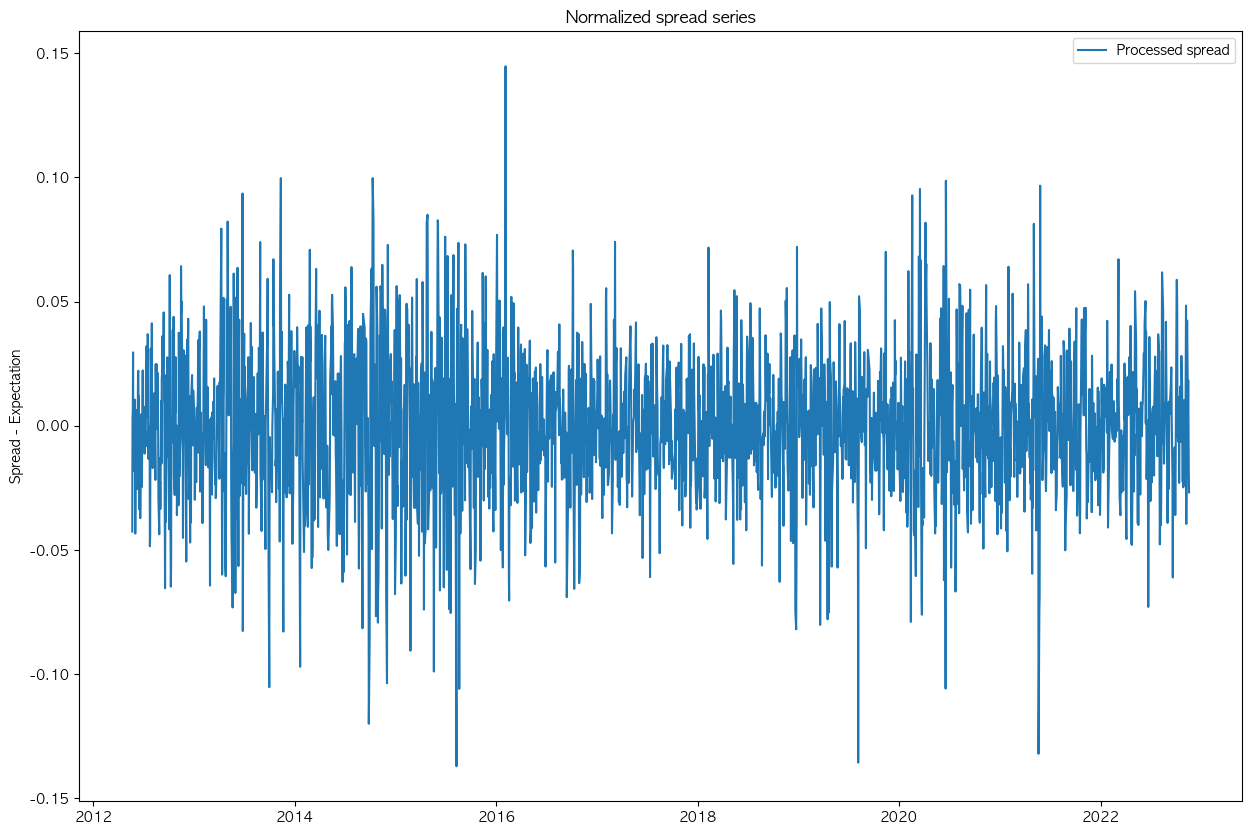

In [88]:
plt.figure(figsize=(15, 10))
plt.plot(normalized_spread, label="Processed spread")
plt.title("Normalized spread series")
plt.ylabel("Spread - Expectation")
plt.legend()
plt.show()

In [89]:
s0 = np.linspace(0, max(normalized_spread), 50)

In [90]:
f_bar = np.array([None]*50)
for i in range(50):
    f_bar[i] = len(normalized_spread.values[normalized_spread.values > s0[i]]) / normalized_spread.shape[0]


In [91]:
D = np.zeros((49, 50))
for i in range(D.shape[0]):
    D[i, i] = 1
    D[i, i+1] = -1

In [92]:
l = 1.0


In [93]:
f_star = np.linalg.inv(np.eye(50) + l * D.T@D) @ f_bar.reshape(-1, 1)
s_star = [f_star[i]*s0[i] for i in range(50)]

In [94]:
threshold = s0[s_star.index(max(s_star))]
print(f"The optimal threshold is {threshold}")

The optimal threshold is 0.02067663849613419


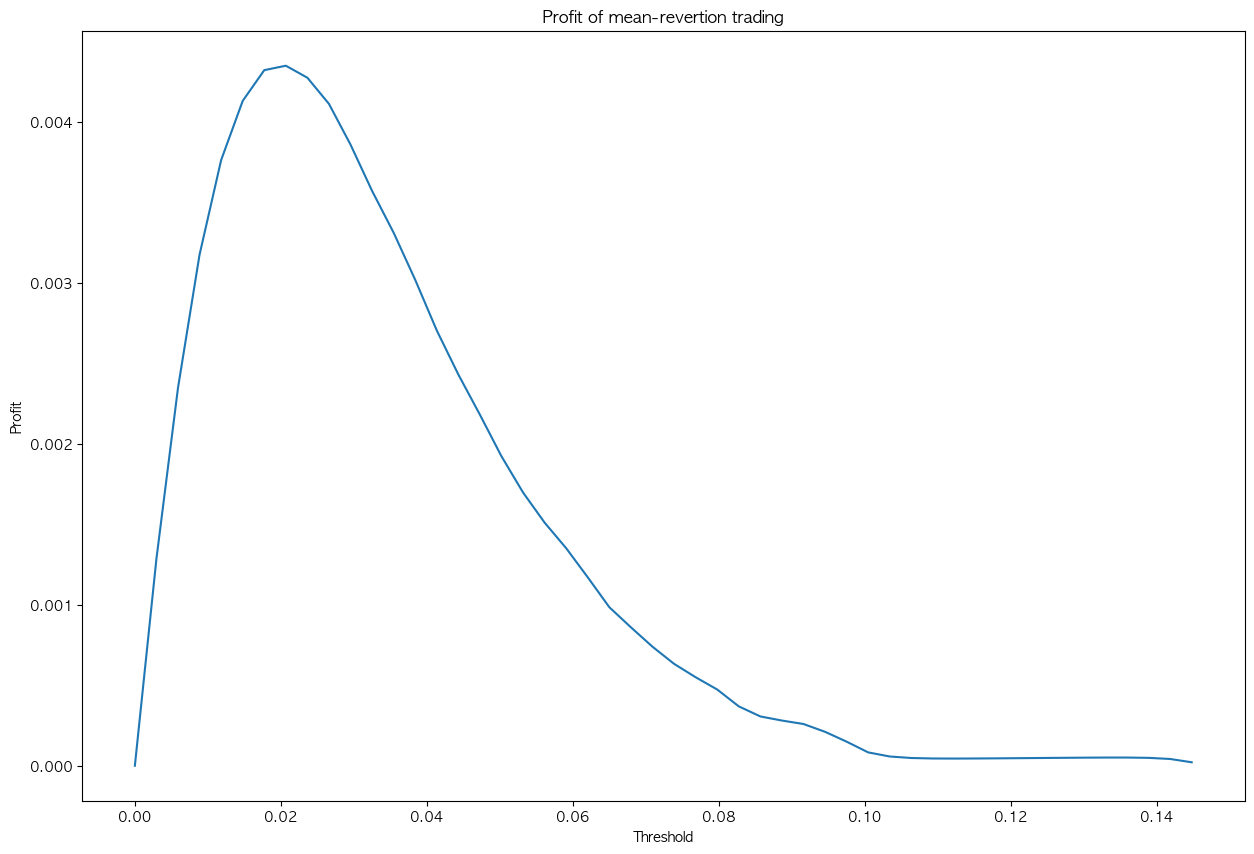

In [95]:
plt.figure(figsize=(15, 10))
plt.plot(s0, s_star)
plt.title("Profit of mean-revertion trading")
plt.xlabel("Threshold")
plt.ylabel("Profit")
plt.show()

In [96]:
trading_weight = beta @ opt.x
trading_weight /= np.sum(abs(trading_weight))

In [97]:
testing_ret = history.pct_change().dropna().shift(-1)   # Shift 1 step backward as forward return result
equity = pd.DataFrame(np.ones((testing_ret.shape[0], 1)), index=testing_ret.index, columns=["Daily value"])

In [98]:
buy_period = normalized_spread[normalized_spread < -threshold].index
sell_period = normalized_spread[normalized_spread > threshold].index

In [99]:
equity.loc[buy_period, "Daily value"] = testing_ret.loc[buy_period] @ trading_weight + 1
equity.loc[sell_period, "Daily value"] = testing_ret.loc[sell_period] @ -trading_weight + 1

In [100]:
value = equity.cumprod()


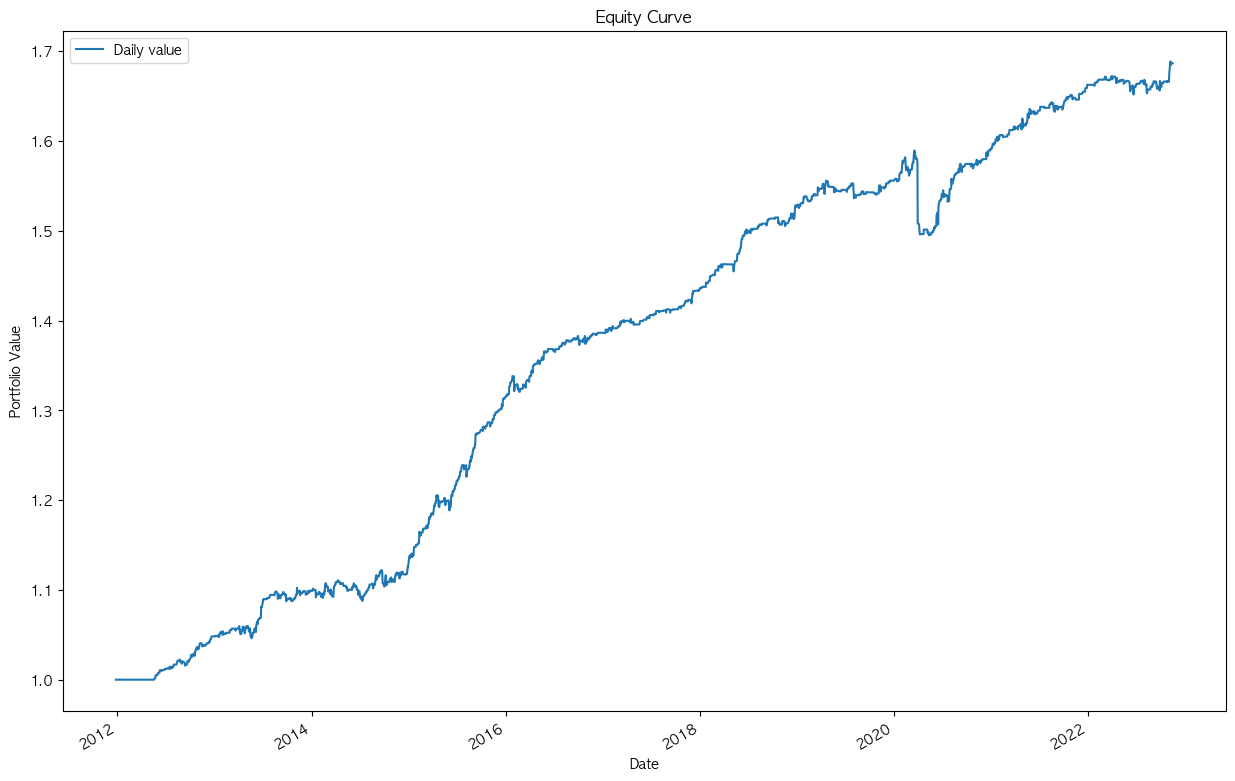

In [101]:
value.plot(title="Equity Curve", figsize=(15, 10))
plt.ylabel("Portfolio Value")
plt.show()